In [1]:
# Add the parent directory to sys.path
import sys, os
from pathlib import Path

current_directory = os.getcwd()
parent_directory = Path(current_directory).parent.parent
sys.path.insert(0, str(parent_directory))
sys.path


['c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis',
 'E:\\python_projects\\CVbot',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\notebooks\\user_overview_analysis',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv',
 '',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\Pythonwin']

# Connect to Database

In [2]:
# Load environment variables
from scripts.utils import load_environment_variables

CREDENTIALS = load_environment_variables(parent_directory=parent_directory)

INFO:scripts.utils:Trying to load environment variables from c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis/.env
INFO:scripts.utils:Credentials loaded successfully


In [3]:
# Connect to the database
from scripts.utils import connect_to_database

connection = connect_to_database({"dbname": CREDENTIALS['DB_NAME'],
                                 "user": CREDENTIALS['USER'],
                                 "host": CREDENTIALS['host'],
                                 "port": CREDENTIALS['port']})

INFO:scripts.utils:Attempting to connect to the database
INFO:scripts.utils:Connection successful


In [4]:
# Load the data from the database into a pandas dataframe
from scripts.utils import load_data_from_db
table_name = 'xdr_data'
df = load_data_from_db(conn=connection,
                       table_name=table_name)

INFO:root:Executing query: SELECT * FROM xdr_data
c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis\scripts\utils.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:scripts.utils:Data loaded into DataFrame successfully


In [5]:
# Close the connection
from scripts.utils import close_database_connection
close_database_connection(conn=connection)

INFO:root:Database connection closed successfully


# Data overview and cleaning

In [6]:
# Import the missing value handler class and create an instance
from scripts.data_processing import MissingValueHandler

handset_df = df[['Handset Type', 'Handset Manufacturer']]
missing_value_handler = MissingValueHandler(handset_df)

INFO:root:MissingValueHandler instance created


In [7]:
# Get summary of missing values
summary = missing_value_handler.missing_value_summary()
summary

INFO:root:Missing value summary computed successfully


Handset Type            572
Handset Manufacturer    572
dtype: int64

In [8]:
# Inspect missing value percentage
percentage = missing_value_handler.missing_value_percentage()
percentage

INFO:root:Missing value percentage computed successfully


Handset Type            0.381331
Handset Manufacturer    0.381331
dtype: float64

- We can see that the missing value percentage is very low

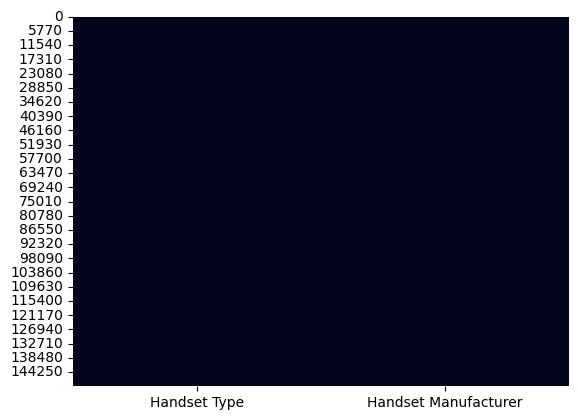

INFO:root:Missing values heatmap displayed successfully


In [9]:
# Show the missing values are very low using heatmap
missing_value_handler.missing_values_heatmap()

- The hitmap also shows most of the data is avaliable and is filled. so we can replace the empty values with `unknown` with out any significant impact on the overall analysis.

In [11]:
# Replace missing values with unknown
handset_df.fillna('unknown', inplace=True)

C:\Users\mekbi\AppData\Local\Temp\ipykernel_7160\2860350042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handset_df.fillna('unknown', inplace=True)


In [12]:
# Inspect missng values now
missing_value_handler.missing_value_summary()

INFO:root:Missing value summary computed successfully


Handset Type            0
Handset Manufacturer    0
dtype: int64

## Handset analysis

- Top 10 handsets

In [13]:
top_10_handsets = handset_df['Handset Type'].value_counts().head(10)
top_10_handsets

Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64

- Since the undefined handsets occupy the fourth place include the elevnth handset and remove the undefined handset from top 10 handsets.

In [14]:
# Transform the top_10_handsets
handset_counts = handset_df['Handset Type'].value_counts()
handset_counts = handset_counts[handset_counts.index != 'undefined']
top_10_handsets = handset_counts.head(10)
top_10_handsets

Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Samsung Galaxy A5 Sm-A520F       3724
Name: count, dtype: int64

- Top 3 manufacturers

In [15]:
top_3_manufacturers = handset_df['Handset Manufacturer'].value_counts().head(3)
top_3_manufacturers

Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64

- Top 5 handset per top 3 manufacturer

In [26]:
top_5_handsets_per_top_3_manufacturers = {}

for manufacturer in top_3_manufacturers.index:
    manufacturer_data = handset_df[handset_df['Handset Manufacturer'] == manufacturer]
    top_5_handsets = manufacturer_data['Handset Type'].value_counts().head(5)

    top_5_handsets_per_top_3_manufacturers[manufacturer] = top_5_handsets

for manufacturer, handsets in top_5_handsets_per_top_3_manufacturers.items():
    print(f"Top 5 handsets for {manufacturer}:")
    print(handsets)
    print("\n")

Top 5 handsets for Apple:
Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64


Top 5 handsets for Samsung:
Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galaxy J5 (Sm-J530)     3696
Samsung Galaxy J3 (Sm-J330)     3484
Samsung Galaxy S7 (Sm-G930X)    3199
Name: count, dtype: int64


Top 5 handsets for Huawei:
Handset Type
Huawei B528S-23A                  19752
Huawei E5180                       2079
Huawei P20 Lite Huawei Nova 3E     2021
Huawei P20                         1480
Huawei Y6 2018                      997
Name: count, dtype: int64




## Visualizations

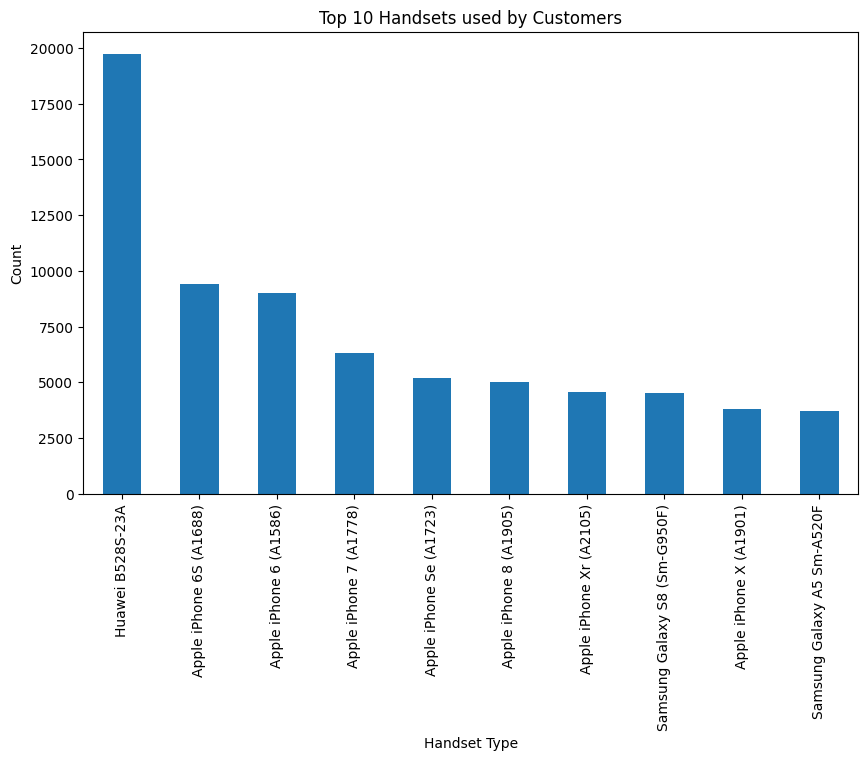

In [27]:
# plot top 10 handsets
import matplotlib.pyplot as plt

top_10_handsets.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Handsets used by Customers')
plt.xlabel('Handset Type')
plt.ylabel('Count')
plt.show()


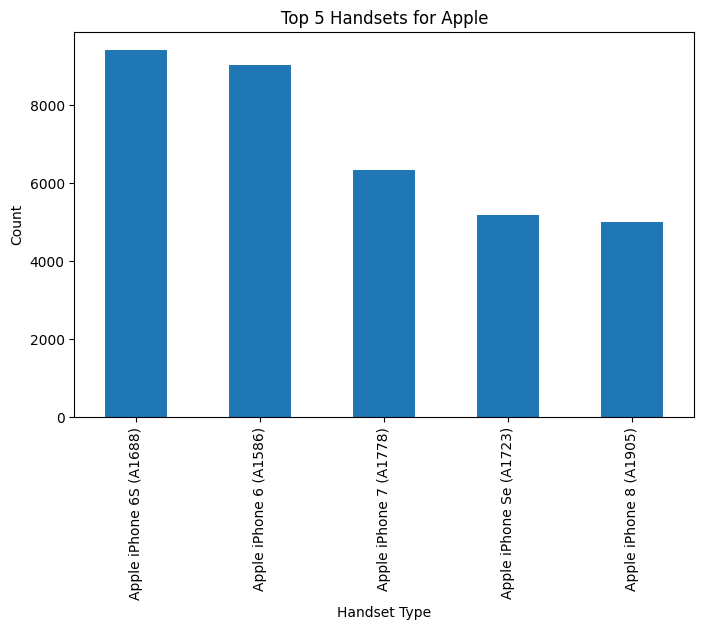

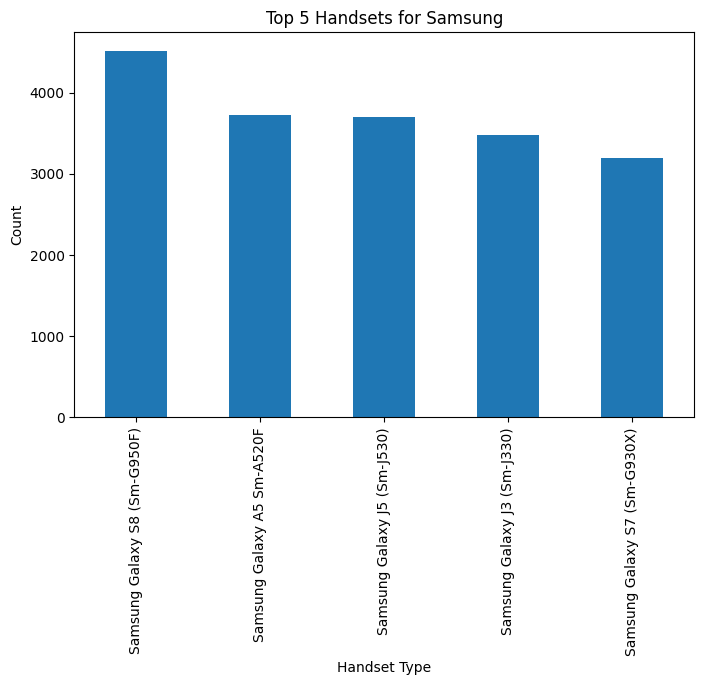

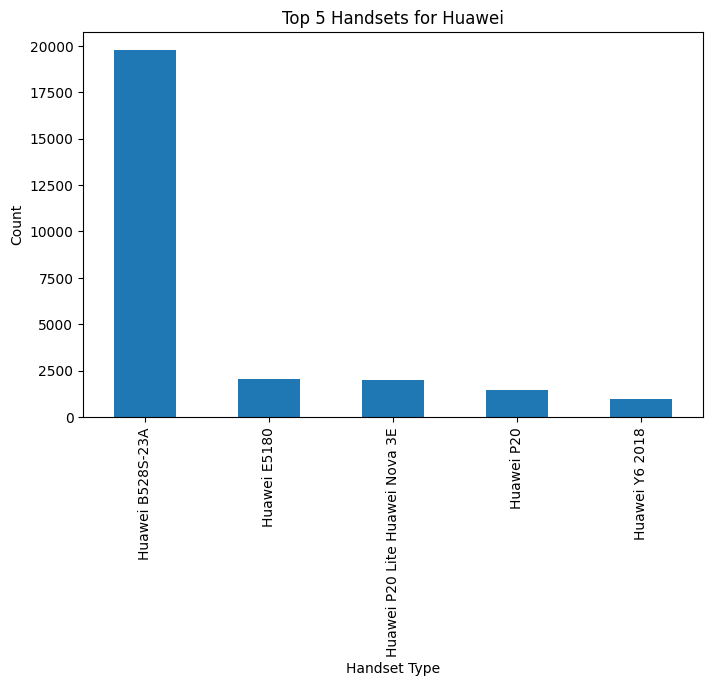

In [28]:
# plot top 5 handsets per top 3 manufacturers
for manufacturer, handsets in top_5_handsets_per_top_3_manufacturers.items():
    handsets.plot(kind='bar', figsize=(8, 5)) 
    plt.title(f'Top 5 Handsets for {manufacturer}')
    plt.xlabel('Handset Type')
    plt.ylabel('Count')
    plt.show()  